In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
latt_size = (16, 16, 8, 8)
# latt_size = (8, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-6

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.172392291371309e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, verbose=verbose)

self.dof_list:[12, 24, 24, 24, 24, 4, 4, 24, 12, 12, 12, 24, 24, 24, 24, 48, 48, 24, 8, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 16x16x8x8
  Level 1: 8x8x4x4
  Level 2: 4x4x2x2
self.grid_list:[[8, 8, 16, 16], [4, 4, 8, 8], [2, 2, 4, 4]]
Norm of b:496.8489190829809
Norm of r:702.0913388519872
Norm of x0:442.665398691082
BICGSTAB-Iteration 0: Residual = 1.209109e+02, Time = 0.013897 s
BICGSTAB-Iteration 1: Residual = 3.965653e+01, Time = 0.012854 s
BICGSTAB-Iteration 2: Residual = 6.257557e+01, Time = 0.012650 s
BICGSTAB-Iteration 3: Residual = 1.322394e+01, Time = 0.012720 s
BICGSTAB-Iteration 4: Residual = 9.145184e+00, Time = 0.012943 s
BICGSTAB-Iteration 5: Residual = 5.587011e+00, Time = 0.013093 s
BICGSTAB-Iteration 6: Residual = 4.698281e+00, Time = 0.013215 s
BICGSTAB-Iteration 7: Residual = 6.961979e+00, Time = 0.012968 s
BICGSTAB-Iteration 8: Residual = 3.633840e+00, Time = 0.012983 s
BICGSTAB-Iteration 9: Residual = 2.96

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 0 ns, sys: 7.44 ms, total: 7.44 ms
Wall time: 6.49 ms
CPU times: user 0 ns, sys: 1.8 ms, total: 1.8 ms
Wall time: 1.55 ms
443.40500673763256
0.0
497.0232896989116
497.0232896989116
1.396478659923767e-16
CPU times: user 42.5 ms, sys: 19.5 ms, total: 62 ms
Wall time: 60.7 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 3.95 ms, sys: 0 ns, total: 3.95 ms
Wall time: 3.12 ms
CPU times: user 2.53 ms, sys: 0 ns, total: 2.53 ms
Wall time: 2.35 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000-2.8319e-16j, 1.0000+1.5399e-16j, 1.0000-1.0052e-16j,
        1.0000+5.1080e-16j, 1.0000+6.5752e-17j, 1.0000-1.5908e-16j,
        1.0000-2.4605e-17j, 1.0000+1.0104e-16j, 1.0000+1.3178e-16j,
        1.0000+3.8261e-16j, 1.0000-3.8763e-16j, 1.0000+8.6968e-17j,
        1.0000+1.3763e-16j, 1.0000-1.1426e-17j, 1.0000+2.2012e-16j,
        1.0000-9.2711e-17j, 1.0000+1.0983e-16j, 1.0000+2.6463e-16j,
        1.0000-1.5798e-17j, 1.0000+6.4565e-17j, 1.0000+1.5549e-16j,
        1.0000+1.1760e-16j, 1.0000-5.7946e-17j, 1.0000+6.0481e-17j,
        1.0000-5.5142e-16j, 1.0000-1.3034e-16j, 1.0000+1.2827e-16j,
        1.0000-7.0350e-17j, 1.0000+2.0648e-16j, 1.0000+8.5401e-17j,
        

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, tol=tol, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, tol=tol, verbose=verbose)

Norm of b:442.82798787465305
Norm of r:664.9245558884963
Norm of x0:443.52176180130994
BICGSTAB-Iteration 0: Residual = 1.432518e+02, Time = 0.012855 s
BICGSTAB-Iteration 1: Residual = 6.002547e+01, Time = 0.013093 s
BICGSTAB-Iteration 2: Residual = 6.789970e+01, Time = 0.012923 s
BICGSTAB-Iteration 3: Residual = 3.921679e+01, Time = 0.012970 s
BICGSTAB-Iteration 4: Residual = 2.437815e+01, Time = 0.012744 s
BICGSTAB-Iteration 5: Residual = 2.294027e+01, Time = 0.012278 s
BICGSTAB-Iteration 6: Residual = 1.500216e+01, Time = 0.011998 s
BICGSTAB-Iteration 7: Residual = 1.260344e+01, Time = 0.012151 s
BICGSTAB-Iteration 8: Residual = 1.148100e+01, Time = 0.012671 s
BICGSTAB-Iteration 9: Residual = 7.121310e+00, Time = 0.012890 s
BICGSTAB-Iteration 10: Residual = 6.244759e+00, Time = 0.012956 s
BICGSTAB-Iteration 11: Residual = 5.942115e+00, Time = 0.013146 s
BICGSTAB-Iteration 12: Residual = 5.147139e+00, Time = 0.012956 s
BICGSTAB-Iteration 13: Residual = 5.261329e+00, Time = 0.012863 s

MG-0:Norm of b:442.82798787465305
MG-0:Norm of r:442.82798787465305
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.130803e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:65.3607245899947
MG-1:Norm of r:65.3607245899947
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 2.460965e+01
F-MG-1-BICGSTAB-Iteration 0: Residual = 2.460965e+01, Time = 0.002556 s
B-MG-1-BICGSTAB-Iteration 1: Residual = 1.354111e+01
F-MG-1-BICGSTAB-Iteration 1: Residual = 1.354111e+01, Time = 0.002483 s
B-MG-1-BICGSTAB-Iteration 2: Residual = 2.182962e+01
F-MG-1-BICGSTAB-Iteration 2: Residual = 2.182962e+01, Time = 0.003341 s
B-MG-1-BICGSTAB-Iteration 3: Residual = 9.754430e+00
F-MG-1-BICGSTAB-Iteration 3: Residual = 9.754430e+00, Time = 0.003116 s
B-MG-1-BICGSTAB-Iteration 4: Residual = 9.950975e+00
F-MG-1-BICGSTAB-Iteration 4: Residual = 9.950975e+00, Time = 0.002575 s
B-MG-1-BICGSTAB-Iteration 5: Residual = 5.757

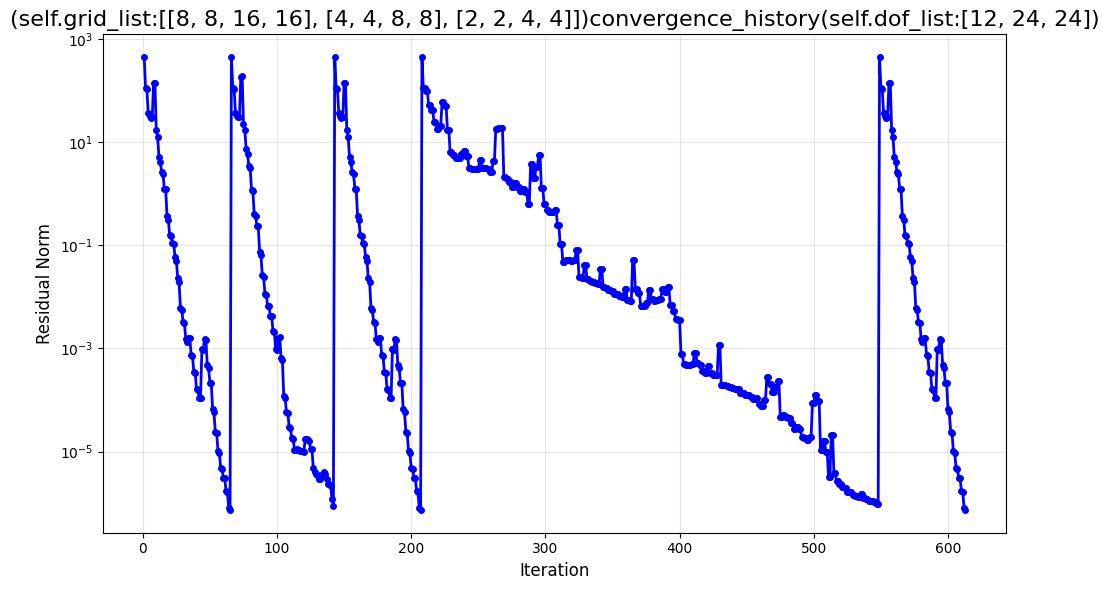

In [22]:
mg.num_levels = 2
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 1.0563e-09+9.6140e-10j, -1.0477e-10-1.9355e-10j,
         1.6158e-09-1.9015e-10j,  2.5349e-10-1.1693e-09j,
         1.1829e-09+4.4435e-10j,  7.2263e-11-2.8412e-10j,
         6.9973e-10+1.6296e-09j, -3.6604e-10+6.1632e-10j,
        -8.1414e-10+1.3690e-09j, -6.7273e-10+3.6742e-10j,
         3.0797e-10+1.9523e-09j,  7.1276e-10+9.2326e-10j,
         6.9690e-10+7.8085e-10j,  4.3325e-10+3.3197e-10j,
         1.1331e-10+2.5880e-10j,  1.1183e-10+5.6505e-10j,
         2.1378e-10+4.6416e-10j,  9.4892e-10+1.1647e-09j,
        -6.5363e-10+8.5115e-10j,  4.8383e-10+2.2178e-10j,
        -7.8582e-10+4.0150e-10j,  5.2760e-10+5.4342e-10j,
         2.1539e-10+1.4861e-11j,  2.0137e-10+7.2252e-10j,
        -6.0377e-10+1.5114e-09j, -3.4332e-10+1.7727e-09j,
         1.3651e-09+1.1996e-09j, -6.9245e-10+1.5456e-09j,
         1.1827e-09+7.1925e-10j, -2.0696e-10+2.1347e-10j,
        -1.2431e-10-2.2558e-10j,  1.0772e-09+4.3513e-10j,
         1.0868e-10+5.5911e-10j,  7.0128e-10+2.2106e-09j,
         4.660

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

1.1996499585451146e-07


In [13]:
mg.num_levels

2

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([2.9610e-02+0.0016j, 2.6784e-02+0.0035j, 2.2810e-02-0.0056j,
        1.9457e-02-0.0033j, 1.2332e-02-0.0109j, 9.1854e-03-0.0096j,
        9.5212e-05-0.0096j, 6.2890e-03-0.0157j, 1.5774e-03-0.0050j,
        8.8306e-03-0.0107j], device='cuda:0', dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([ 0.0047+0.0035j, -0.0002+0.0038j,  0.0022+0.0048j,  0.0004+0.0009j,
         0.0032+0.0043j,  0.0115+0.0013j,  0.0146+0.0001j,  0.0200+0.0039j,
         0.0224+0.0009j,  0.0234+0.0037j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0019-0.0043j,  0.0249-0.0044j, -0.0127+0.0055j,  0.0135-0.0078j,
        -0.0225-0.0047j,  0.0099+0.0100j,  0.0095+0.0108j,  0.0068+0.0247j,
         0.0207+0.0097j,  0.0124+0.0139j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0197-0.0094j, 0.0230-0.006

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([-0.0083-0.0080j, -0.0065-0.0076j, -0.0054-0.0076j, -0.0051-0.0078j,
        -0.0058-0.0086j, -0.0083-0.0089j, -0.0102-0.0092j, -0.0102-0.0084j,
        -0.0094-0.0076j, -0.0074-0.0065j, -0.0062-0.0062j, -0.0063-0.0071j,
        -0.0068-0.0083j, -0.0086-0.0082j, -0.0102-0.0080j, -0.0104-0.0080j,
        -0.0110-0.0054j, -0.0092-0.0050j, -0.0079-0.0052j, -0.0079-0.0051j,
        -0.0083-0.0059j, -0.0094-0.0071j, -0.0108-0.0067j, -0.0119-0.0060j,
        -0.0130-0.0037j, -0.0105-0.0036j, -0.0099-0.0032j, -0.0095-0.0036j,
        -0.0098-0.0046j, -0.0104-0.0056j, -0.0115-0.0052j, -0.0129-0.0043j,
        -0.0130-0.0039j, -0.0114-0.0039j, -0.0103-0.0036j, -0.0103-0.0037j,
        -0.0108-0.0048j, -0.0119-0.0052j, -0.0129-0.0047j, -0.0136-0.0047j,
        -0.0125-0.0052j, -0.0108-0.0049j, -0.0097-0.0059j, -0.0099-0.0056j,
        -0.0105-0.0066j, -0.0119-0.0063j, -0.0133-0.0052j, -0.0138-0.0050j,
        -0.0098-0.0065j, -0.0089-0.0069j, -0.0074-0.0075j, -0.0074-0.0075j,
        -0.0

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(495.5740, device='cuda:0', dtype=torch.float64)
tensor([-0.9301+0.1655j,  1.0642-1.0187j,  0.1578+1.7385j,  0.5534-1.1811j,
        -0.0530+0.5550j, -0.6252-2.5803j, -0.7322+0.5883j, -0.0252+0.1804j,
        -0.1422-0.0628j,  0.1513+0.6382j, -0.6308-0.2544j,  0.5003-0.1291j,
         0.8846+0.3306j, -0.4361+1.0535j, -0.1540-0.7522j, -0.1224+0.5302j,
         1.7814-0.0420j,  0.8128-0.7382j, -0.0912+0.3307j, -0.5397+1.0378j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:495.5739925627657
Norm of r:700.4224887099971
Norm of x0:442.8708318604005
BICGSTAB-Iteration 0: Residual = 1.207991e+02, Time = 0.012384 s
BICGSTAB-Iteration 1: Residual = 3.949643e+01, Time = 0.012329 s
BICGSTAB-Iteration 2: Residual = 6.373624e+01, Time = 0.012384 s
BICGSTAB-Iteration 3: Residual = 1.318824e+01, Time = 0.012618 s
BICGSTAB-Iteration 4: Residual = 8.461982e+00, Time = 0.012896 s
BICGSTAB-Iteration 5: Residual = 6.393645e+00, Time = 0.013167 s
BICGSTAB-Iteration 6: Residual = 5.521805

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:443.7193747128637
Norm of r:667.0894137743694
Norm of x0:443.6490785219461
BICGSTAB-Iteration 0: Residual = 1.437567e+02, Time = 0.013684 s
BICGSTAB-Iteration 1: Residual = 6.095761e+01, Time = 0.013450 s
BICGSTAB-Iteration 2: Residual = 6.590105e+01, Time = 0.013205 s
BICGSTAB-Iteration 3: Residual = 3.984279e+01, Time = 0.013291 s
BICGSTAB-Iteration 4: Residual = 2.485570e+01, Time = 0.013201 s
BICGSTAB-Iteration 5: Residual = 1.821586e+01, Time = 0.013247 s
BICGSTAB-Iteration 6: Residual = 1.743107e+01, Time = 0.012923 s
BICGSTAB-Iteration 7: Residual = 2.195824e+01, Time = 0.012170 s
BICGSTAB-Iteration 8: Residual = 1.258354e+01, Time = 0.012609 s
BICGSTAB-Iteration 9: Residual = 9.737644e+00, Time = 0.012658 s
BICGSTAB-Iteration 10: Residual = 2.180089e+01, Time = 0.012201 s
BICGSTAB-Iteration 11: Residual = 7.768428e+00, Time = 0.014115 s
BICGSTAB-Iteration 12: Residual = 4.819202e+00, Time = 0.013289 s
BICGSTAB-Iteration 13: Residual = 4.370855e+00, Time = 0.013011 s
B

In [18]:
_null_vec.flatten()[:100]

tensor([ 1.0627e-03-1.2772e-03j,  7.6333e-04-7.5194e-04j,
         4.0960e-04-7.5069e-04j,  4.3079e-04-2.3949e-04j,
         6.8688e-04-2.6245e-04j,  6.4304e-04-9.6579e-04j,
        -5.4806e-05-9.8105e-04j,  6.7404e-04-5.1384e-04j,
         6.8172e-04-1.6813e-04j,  4.6581e-04-3.2642e-04j,
         1.0378e-03-3.4075e-04j,  1.4799e-03-3.7822e-04j,
         1.3218e-03-3.3654e-04j,  1.2359e-03-5.7225e-04j,
         1.1159e-03-4.3350e-04j,  1.3264e-03-5.2823e-04j,
         1.4073e-03-5.8604e-04j,  5.6454e-04-3.0867e-04j,
         3.4313e-04-6.4189e-04j,  6.3679e-04-4.1076e-04j,
         5.9038e-04-1.1502e-03j,  7.8151e-04-9.8506e-04j,
         7.7226e-04-6.5717e-04j,  8.0449e-04-4.0527e-04j,
         4.2642e-04-5.9532e-04j,  8.6373e-04-4.5272e-04j,
         1.2925e-03-3.5053e-04j,  1.3225e-03-8.0502e-04j,
         1.5967e-03-7.2341e-04j,  1.3412e-03-2.7211e-05j,
         1.3968e-03-8.0803e-04j,  1.3417e-03-6.7952e-04j,
         6.5012e-04-8.3618e-04j,  8.5621e-04-6.7891e-04j,
         6.113